<a href="https://colab.research.google.com/github/jiayuankeliang/309CourseWork2/blob/main/implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rustin96","key":"0f80a220c3c09d55b32c93025d2c2d3b"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600  ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 99% 608M/612M [00:03<00:00, 186MB/s]
100% 612M/612M [00:03<00:00, 179MB/s]


In [7]:
import zipfile

filename = '/content/gtsrb-german-traffic-sign.zip'

with zipfile.ZipFile(filename, 'r') as zip_ref:
  zip_ref.extractall('.')

In [8]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

In [9]:
img_height = 32
img_width = 32

In [10]:
data = []
labels = []
classes = 43

with tf.device('/GPU:0'):
  for i in range(classes):
      path = os.path.join('/content/Train',str(i))
      images = os.listdir(path)

      for image in images:
        image = Image.open(os.path.join(path, image))
        image = image.resize((img_height,img_width))
        image = np.array(image)
        data.append(image)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [12]:
X_train.shape, y_train.shape

((31367, 32, 32, 3), (31367,))

In [13]:
X_val.shape, y_val.shape

((7842, 32, 32, 3), (7842,))

In [14]:
X_train = X_train/255
X_val = X_val/255

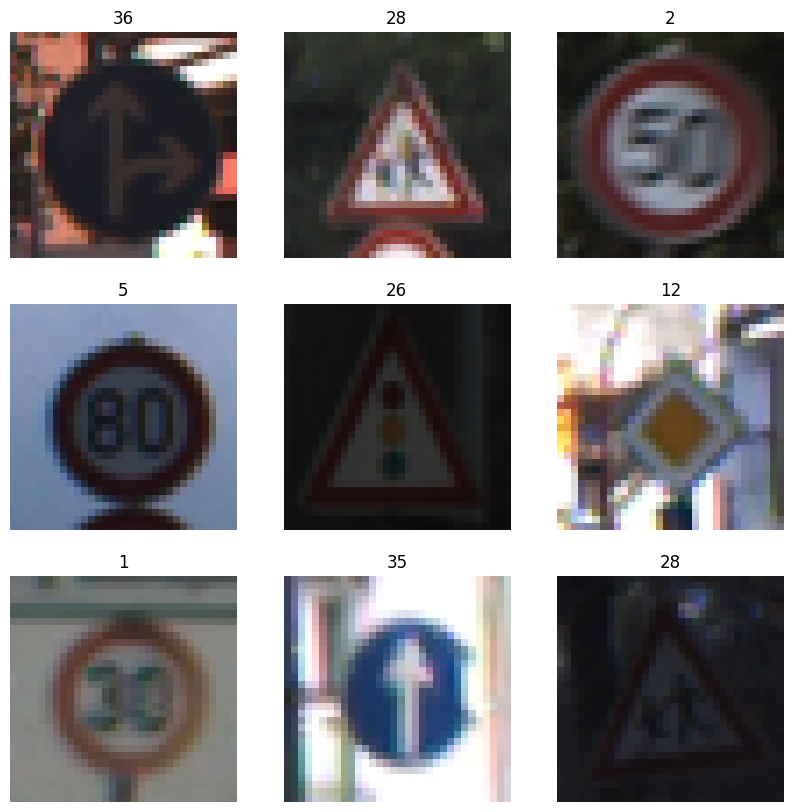

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i])
  plt.title(y_train[i])
  plt.axis("off")

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(classes, activation='softmax')
])

In [17]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [18]:
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
981/981 [==============================] - 22s 10ms/step - loss: 1.4336 - accuracy: 0.5839 - val_loss: 0.1300 - val_accuracy: 0.9620
Epoch 2/20
981/981 [==============================] - 10s 10ms/step - loss: 0.1981 - accuracy: 0.9396 - val_loss: 0.0456 - val_accuracy: 0.9846
Epoch 3/20
981/981 [==============================] - 10s 10ms/step - loss: 0.1021 - accuracy: 0.9698 - val_loss: 0.0281 - val_accuracy: 0.9916
Epoch 4/20
981/981 [==============================] - 10s 10ms/step - loss: 0.0680 - accuracy: 0.9805 - val_loss: 0.0179 - val_accuracy: 0.9954
Epoch 5/20
981/981 [==============================] - 10s 10ms/step - loss: 0.0483 - accuracy: 0.9860 - val_loss: 0.0152 - val_accuracy: 0.9966
Epoch 6/20
981/981 [==============================] - 10s 10ms/step - loss: 0.0505 - accuracy: 0.9864 - val_loss: 0.0104 - val_accuracy: 0.9968
Epoch 7/20
981/981 [==============================] - 9s 10ms/step - loss: 0.0426 - accuracy: 0.9884 - val_loss: 0.0162 - val_accuracy: 

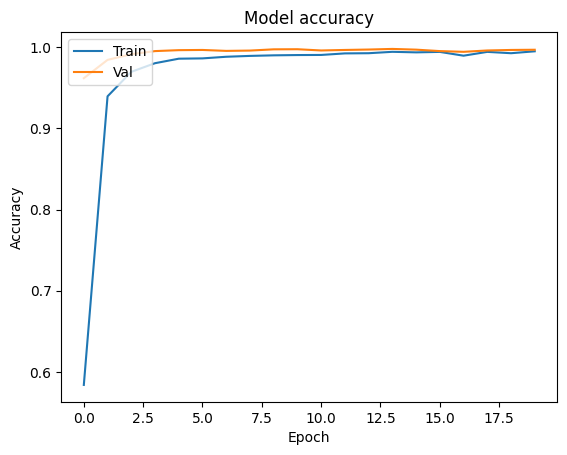

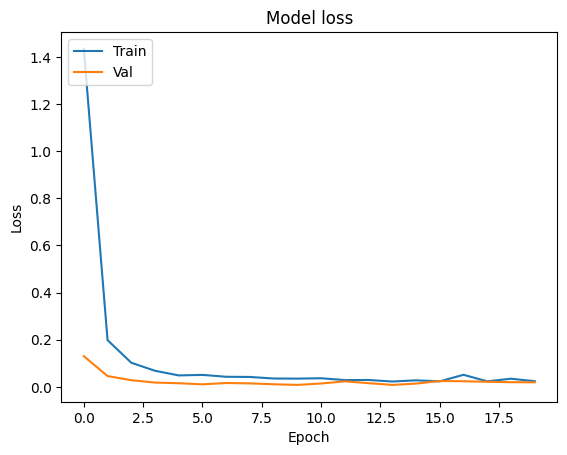

In [19]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [20]:
test = pd.read_csv('/content/Test.csv')

y_test = test["ClassId"].values
imgs = test["Path"].values

data=[]

with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/'+img)
        image = image.resize([img_height, img_width])
        data.append(np.array(image))

X_test=np.array(data)

In [21]:
X_test = X_test/255
model_predict = model.predict(X_test)

correct_predict = []
incorrect_predict = []

for i in range(len(model_predict)):
  label = np.argmax(model_predict[i])
  if label == y_test[i]:
    correct_predict.append(i)
  else:
    incorrect_predict.append(i)

accuracay = len(correct_predict) / (len(correct_predict) + len(incorrect_predict))
print('accuracay: {}'.format(accuracay))

395/395 [==============================] - 2s 4ms/step
accuracay: 0.9764845605700713


In [22]:
layer_outputs = [layer.output for layer in model.layers[0:6]]

In [23]:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

1/1 [==============================] - 0s 20ms/step


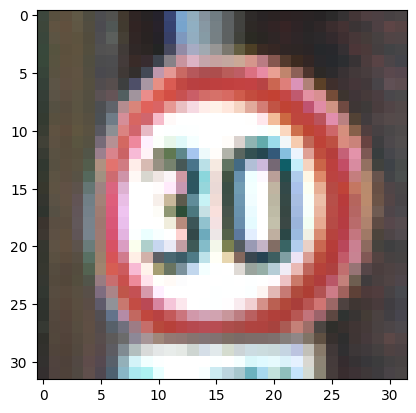

In [32]:
img = X_test[1]
plt.imshow(img)
img = img.reshape(1, 32, 32, 3)
activations = activation_model.predict(img)

In [33]:
for i in activations:
  print(i.shape)

(1, 32, 32, 32)
(1, 32, 32, 64)
(1, 16, 16, 64)
(1, 16, 16, 128)
(1, 16, 16, 256)
(1, 8, 8, 256)


<function matplotlib.pyplot.show(close=None, block=None)>

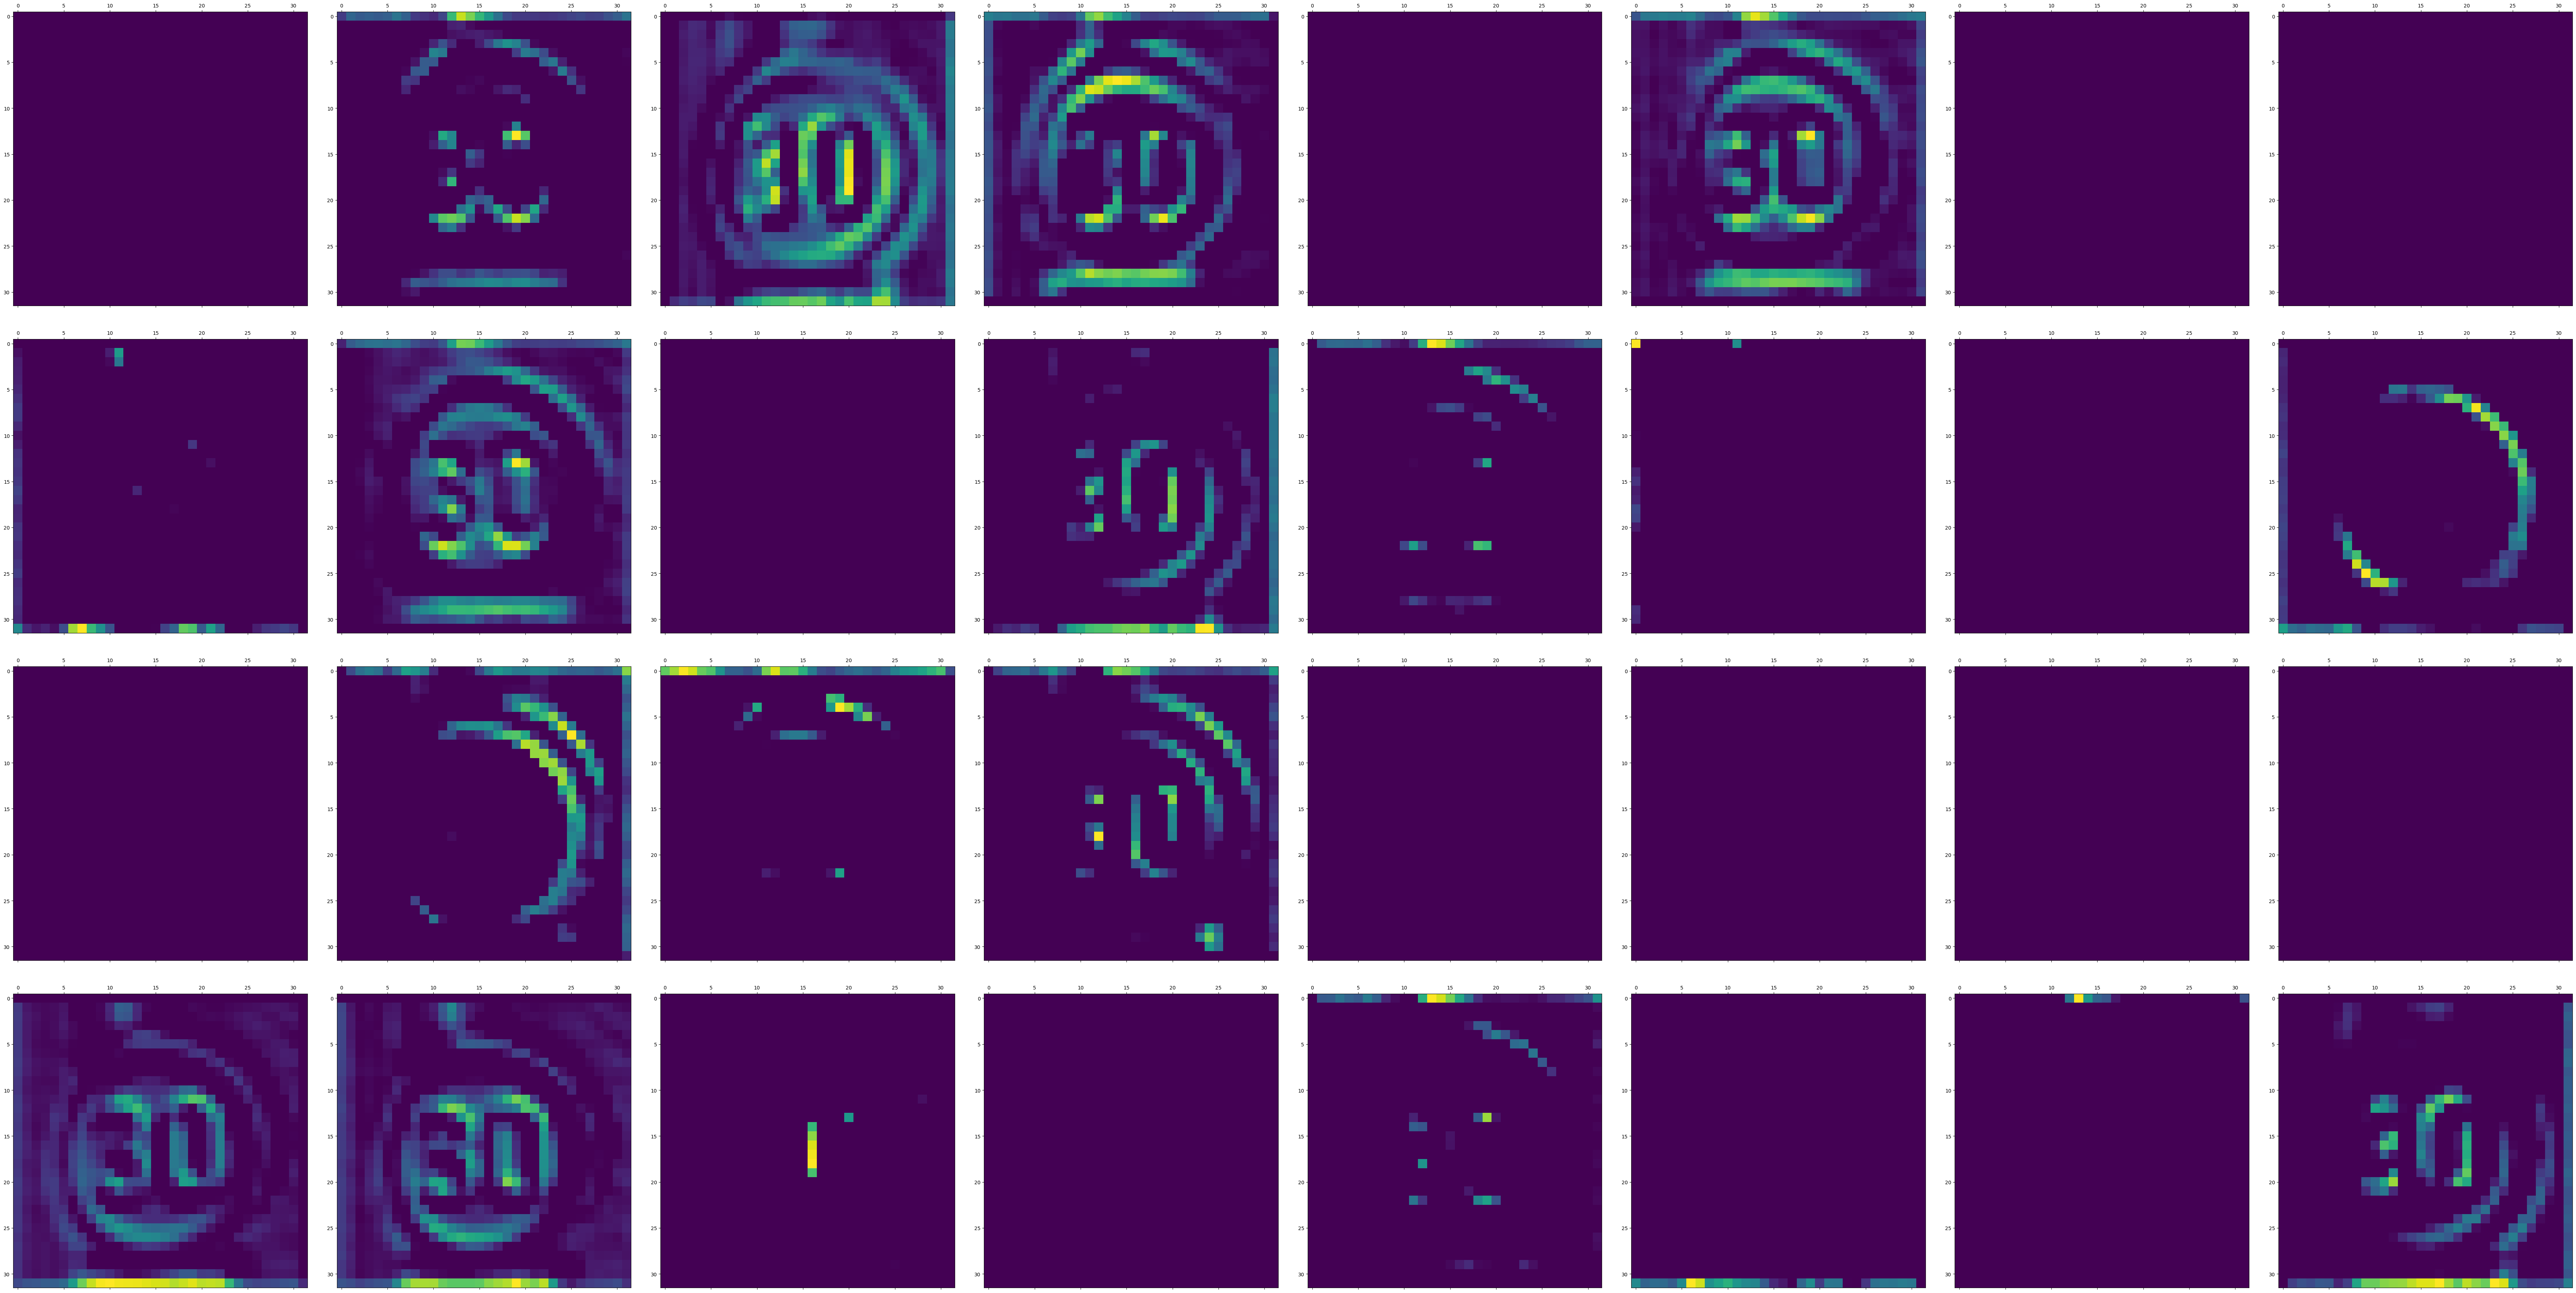

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(80, 40))
for i in range(4):
  for j in range(8):
    ax[i, j].matshow(activations[0][0, :, :, i * 8 + j])
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.show

In [35]:
fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(80, 80))
for i in range(8):
  for j in range(8):
    ax[i, j].matshow(activations[1][0, :, :, i * 8 + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [36]:
fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(80, 80))
for i in range(8):
  for j in range(8):
    ax[i, j].matshow(activations[2][0, :, :, i * 8 + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [37]:
fig, ax = plt.subplots(nrows=16, ncols=8, figsize=(80, 160))
for i in range(16):
  for j in range(8):
    ax[i, j].matshow(activations[3][0, :, :, i * 8 + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [64]:
fig, ax = plt.subplots(nrows=8, ncols=16, figsize=(80, 160))
for i in range(16):
  for j in range(8):
    ax[i, j].matshow(activations[4][0, :, :, i + j], cmap='viridis')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
plt.grid(False)
plt.show

IndexError: ignored